In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
data = pd.read_csv('DATABEFOREPERCENTILE.csv')

In [18]:
data.drop(columns=['Unnamed: 0'], inplace = True)

In [19]:
mis = data.isnull().sum()
mis

Country Name                                                                0
Time                                                                        0
Exports of goods and services (% of GDP)                                    0
Foreign direct investment, net inflows (% of GDP)                           0
GDP (current US$)                                                           0
GDP growth (annual %)                                                       0
GDP per capita (current US$)                                                0
GDP per capita growth (annual %)                                            0
Inflation, GDP deflator (annual %)                                          0
Trade (% of GDP)                                                            0
Imports of goods and services (% of GDP)                                    0
Gross capital formation (annual % growth)                                   0
Unemployment, total (% of total labor force) (modeled ILO estima

In [20]:
import pandas as pd

def load_and_preprocess_data(data):
    data['Time'] = pd.to_datetime(data['Time'], format='%Y')
    data = data.set_index('Time')
    return data

data = load_and_preprocess_data(data)
south_africa_data = data[data['Country Name'] == 'South Africa']


In [21]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())  # Drop NA values for the test
    return result[1]  # Return the p-value

adf_results = {}

for column in south_africa_data.columns:
    if column != 'Country Name':
        adf_p_value = adf_test(south_africa_data[column])
        adf_results[column] = adf_p_value

stationary_count = sum(p_value < 0.1 for p_value in adf_results.values())
non_stationary_count = len(adf_results) - stationary_count

print(f"Number of stationary indicators: {stationary_count}")
print(f"Number of non-stationary indicators: {non_stationary_count}")
print(f"Percentage of stationary indicators: {stationary_count / len(adf_results) * 100:.2f}%")
print(f"Percentage of non-stationary indicators: {non_stationary_count / len(adf_results) * 100:.2f}%")


Number of stationary indicators: 10
Number of non-stationary indicators: 21
Percentage of stationary indicators: 32.26%
Percentage of non-stationary indicators: 67.74%


In [22]:
south_africa_gdp = south_africa_data['GDP (current US$)']

adf_result_gdp = adfuller(south_africa_gdp)
print(f"ADF Statistic: {adf_result_gdp[0]}")
print(f"p-value: {adf_result_gdp[1]}")
for key, value in adf_result_gdp[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.950343100371003
p-value: 0.30876099769472154
Critial Values:
   1%, -4.137829282407408
Critial Values:
   5%, -3.1549724074074077
Critial Values:
   10%, -2.7144769444444443


In [23]:
south_africa_gdp_diff = south_africa_gdp.diff().dropna()

adf_result_gdp_diff = adfuller(south_africa_gdp_diff)
print(f"ADF Statistic (Differenced): {adf_result_gdp_diff[0]}")
print(f"p-value (Differenced): {adf_result_gdp_diff[1]}")
for key, value in adf_result_gdp_diff[4].items():
    print('Critical Values (Differenced):')
    print(f'   {key}, {value}')


ADF Statistic (Differenced): -1.9086326593175402
p-value (Differenced): 0.328010996897534
Critical Values (Differenced):
   1%, -4.01203360058309
Critical Values (Differenced):
   5%, -3.1041838775510207
Critical Values (Differenced):
   10%, -2.6909873469387753


In [24]:
south_africa_gdp_diff2 = south_africa_gdp_diff.diff().dropna()

adf_result_gdp_diff2 = adfuller(south_africa_gdp_diff2)
print(f"ADF Statistic (Second-Order Differenced): {adf_result_gdp_diff2[0]}")
print(f"p-value (Second-Order Differenced): {adf_result_gdp_diff2[1]}")
for key, value in adf_result_gdp_diff2[4].items():
    print('Critical Values (Second-Order Differenced):')
    print(f'   {key}, {value}')


ADF Statistic (Second-Order Differenced): 2.354846547156886
p-value (Second-Order Differenced): 0.9989874504552074
Critical Values (Second-Order Differenced):
   1%, -4.331573
Critical Values (Second-Order Differenced):
   5%, -3.23295
Critical Values (Second-Order Differenced):
   10%, -2.7487


### 

Given the non-stationarity observed even after differencing l1 and l2, we proceed with ARIMA modeling by including an appropriate level of differencing (d) to account for the non-stationarity.

In [25]:
south_africa_gdp_diff

Time
2004-01-01    5.878794e+10
2005-01-01    3.306031e+10
2006-01-01    1.499146e+10
2007-01-01    2.921844e+10
2008-01-01   -1.694586e+10
2009-01-01    1.362280e+10
2010-01-01    8.760976e+10
2011-01-01    4.083567e+10
2012-01-01   -2.379895e+10
2013-01-01   -3.351453e+10
2014-01-01   -1.968714e+10
2015-01-01   -3.448908e+10
2016-01-01   -2.312428e+10
2017-01-01    5.786330e+10
2018-01-01    2.381191e+10
2019-01-01   -1.593069e+10
2020-01-01   -5.103864e+10
2021-01-01    8.182642e+10
2022-01-01   -1.484696e+10
Name: GDP (current US$), dtype: float64

Shape of differenced GDP data: (19,)
First few values of the differenced data:
Time
2004-01-01    5.878794e+10
2005-01-01    3.306031e+10
2006-01-01    1.499146e+10
2007-01-01    2.921844e+10
2008-01-01   -1.694586e+10
Name: GDP (current US$), dtype: float64


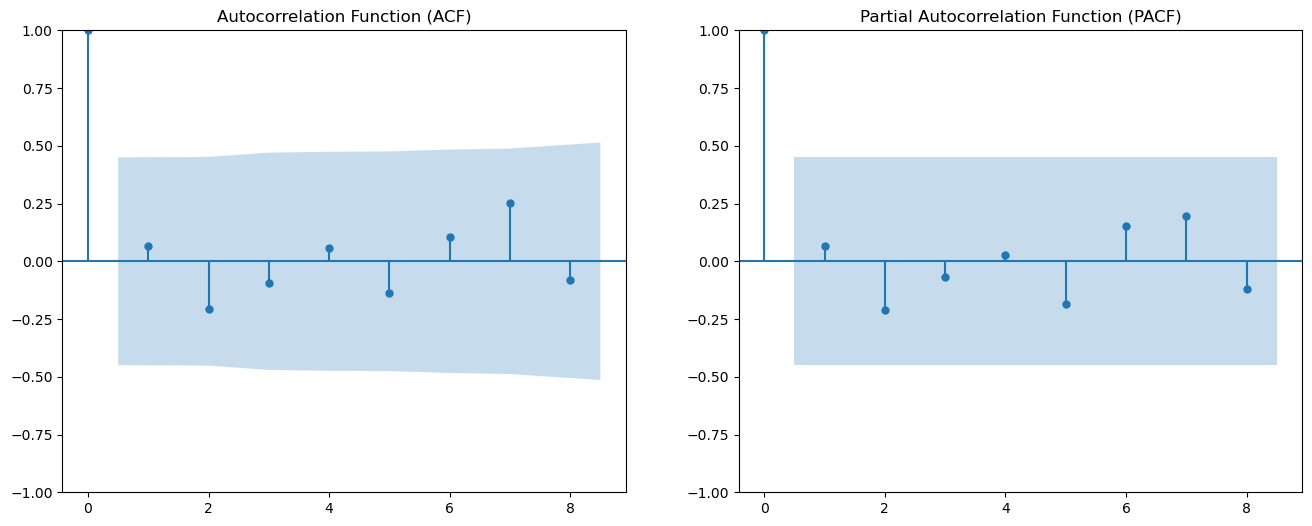

In [32]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print(f"Shape of differenced GDP data: {south_africa_gdp_diff.shape}")
print(f"First few values of the differenced data:\n{south_africa_gdp_diff.head()}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(south_africa_gdp_diff, lags=8, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(south_africa_gdp_diff, lags=8, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.savefig('/Users/sahilbhardwaj/AA - PUSH VC/Dissertation Files/METHODOLOGY AND EVALS /Percentile and Scoring/EVALUATION - FORECASTING/PLOTS/PACF.png')
plt.show()



In [12]:
pwd

'/Users/sahilbhardwaj/AA - PUSH VC/Dissertation Files/METHODOLOGY AND EVALS /Percentile and Scoring/EVALUATION - FORECASTING'